In [1]:
import math
import cmath
import pickle

import matplotlib.pyplot as plt
import torch

import vrlsnmr

In [2]:
with open("instance.pickle", "rb") as file:
    instance = pickle.load(file)

In [3]:
(k, m, n, stdev) = (instance.k, instance.m, instance.n, instance.stdev)
(A, x0, noise, y) = (instance.A, instance.x0, instance.noise, instance.y)
(B, Phi, ids) = (instance.B, instance.Phi, instance.ids)

In [4]:
tau = torch.tensor(1 / stdev**2)  # noise is known
xi = 1e4

In [5]:
mu = torch.zeros(n).cfloat()
Gamma = torch.eye(n).cfloat()
w = torch.ones(n)

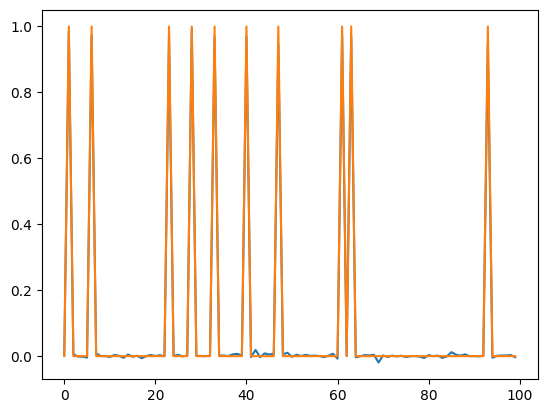

In [6]:
for _ in range(10):
    K = vrlsnmr.kernel(w, ids, tau)
    Kinv = torch.linalg.inv(K)

    mu.mul_(0)
    mu[ids] = Kinv @ y
    mu = torch.fft.fft(mu, norm="ortho") / w

    Gamma_diag = vrlsnmr.xmarginal(Kinv, w, ids)
    
    m2 = mu.abs().square() + Gamma_diag
    w = (xi / (m2 + 1e-9)).sqrt()

plt.plot(mu.real);
plt.plot(x0.real);

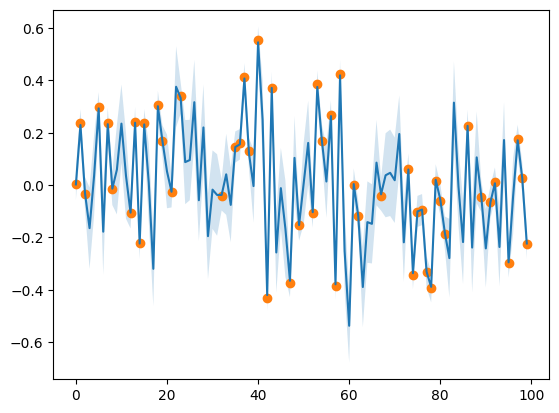

In [8]:
#plt.plot((Phi @ Gamma @ Phi.t().conj()).diag().real);
t = torch.arange(n)
yhat = (Phi @ mu).imag
s = vrlsnmr.ymarginal(Kinv, w, ids)

width = 1e3
plt.fill_between(t, y1=yhat + width * s, y2=yhat - width * s, alpha=0.2);
plt.plot(yhat);
plt.scatter(instance.ids, instance.y.imag);

# Scratchpad
## Analyzing `kernel()`

In [ ]:
Winv = w.reciprocal().diag().cfloat()
K = torch.eye(m) / tau + A @ Winv @ A.t().conj()

In [ ]:
C = Phi @ Winv @ Phi.t().conj()
c0 = C[:,0]

In [ ]:
c = torch.fft.fft(w.reciprocal()).conj() / n

In [ ]:
(c0 - c).abs().max(), (c0 - c).real.abs().max(), (c0 - c).imag.abs().max()

In [ ]:
C[5,2], C[2,5]

In [ ]:
c[2 + (n - 5)].conj(), c[2 + (n - 5)]

In [ ]:
for i in range(n):
    for j in range(i, n):
        assert torch.allclose(C[i,j], c[i - j])
        if j != i:
            assert torch.allclose(C[j,i], c[i - j].conj())

In [ ]:
ids = instance.ids
ids

In [ ]:
for i in range(m):
    assert torch.allclose(K[i,i], c[0] + 1/tau)
    for j in range(i + 1, m):
        k = n + ids[i] - ids[j]
        assert 0 <= k < n
        assert torch.allclose(K[i,j], c[k])
        assert torch.allclose(K[j,i], c[k].conj())

In [ ]:
Kcpp = vrlsnmr.kernel(weights=w, ids=ids, tau=tau)

In [ ]:
K.shape == Kcpp.shape, K.dtype == Kcpp.dtype, torch.allclose(K, Kcpp)

In [ ]:
torch.testing.assert_close(K, Kcpp)

## Analyzing `xmarginal()`

In [ ]:
Gamma_diag = w.reciprocal() - torch.sum((Kinv @ A / w) * A.conj() / w, dim=0).real

In [ ]:
gamma = vrlsnmr.xmarginal(Kinv, w, ids)

In [ ]:
torch.testing.assert_close(Gamma_diag, gamma)

## Analyzing `ymarginal()`

In [ ]:
Winv = w.reciprocal().diag().cfloat()
C = Phi @ Winv @ Phi.t().conj()
K = torch.eye(m) / tau + A @ Winv @ A.t().conj()
Kinv = torch.linalg.inv(K)

Gamma_inv = w.diag() + tau * A.t().conj() @ A
Gamma = torch.linalg.inv(Gamma_inv)

s = (Phi @ Gamma @ Phi.t().conj()).real.diag()

In [ ]:
s_cpp = vrlsnmr.ymarginal(Kinv, w, ids)
torch.testing.assert_close(s, s_cpp)

In [ ]:
c = torch.fft.fft(w.reciprocal()).conj() / n

In [ ]:
beta = lambda k: c.roll(k).index_select(dim=0, index=ids)

In [ ]:
for k in range(n):
    torch.testing.assert_close(
        c.roll(k).index_select(dim=0, index=ids),
        (B.cfloat() @ C.narrow(dim=1, start=k, length=1)).squeeze(dim=1),
    )

In [ ]:
sigma = lambda k: c[0].real - torch.einsum("ij,i,j->", Kinv, beta(k).conj(), beta(k)).real

In [ ]:
for k in range(n):
    torch.testing.assert_close(s[k], sigma(k))

In [ ]:
for j in range(m):
    torch.testing.assert_close(beta(0)[j], c[ids[j]])

In [ ]:
for k in range(n):
    for j in range(m):
        index = (ids[j] - k) % n
        assert 0 <= index < n
        torch.testing.assert_close(beta(k)[j], c[index])